In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, accuracy_score
import pandas as pd
from datetime import datetime
import time
import os
from PIL import Image
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
import zipfile
import tempfile

def load_binary_data(zip_path='Wound_dataset copy.zip', img_size=(224, 224)):
    images = []
    labels = []

    with tempfile.TemporaryDirectory() as tmpdir:
        print(f"Extracting {zip_path} to {tmpdir}")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(tmpdir)

        # Process bruise images (positive class)
        bruise_path = os.path.join(tmpdir, 'Wound_dataset copy', 'Bruises')
        if os.path.exists(bruise_path):
            for img_name in os.listdir(bruise_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(bruise_path, img_name)
                    try:
                        img = Image.open(img_path)
                        img = img.convert('RGB')
                        img = img.resize(img_size)
                        img_array = np.array(img) / 255.0

                        images.append(img_array)
                        labels.append(1)  # 1 for bruise
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")

        # Process normal skin images (negative class)
        normal_path = os.path.join(tmpdir, 'Wound_dataset copy', 'Normal')
        if os.path.exists(normal_path):
            for img_name in os.listdir(normal_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(normal_path, img_name)
                    try:
                        img = Image.open(img_path)
                        img = img.convert('RGB')
                        img = img.resize(img_size)
                        img_array = np.array(img) / 255.0

                        images.append(img_array)
                        labels.append(0)  # 0 for normal
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")


    return np.array(images), np.array(labels)

In [ ]:
# Load the dataset
X, y = load_binary_data()
print("Dataset shape:", X.shape)
print("Number of bruise images:", np.sum(y == 1))
print("Number of normal images:", np.sum(y == 0))

Extracting Wound_dataset copy.zip to /tmp/tmpveatw6x5
Dataset shape: (442, 224, 224, 3)
Number of bruise images: 242
Number of normal images: 200


In [ ]:
def shallow_k3_no_bn_leaky(input_shape, num_classes):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (3, 3)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np

# Configurable variables
optimizers = {
    'adam': Adam,
    'sgd': SGD
}
learning_rates = [0.001, 0.0001]
epoch_strategies = {
    'early_stop': {'epochs': 100, 'callbacks': [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]},
    'fixed_15': {'epochs': 15, 'callbacks': []}
}


In [ ]:
def run_experiment(optimizer_name, lr, epoch_strategy, x_train, y_train, x_val, y_val, input_shape, num_classes):
    print(f"\nRunning: Optimizer={optimizer_name}, LR={lr}, EpochStrategy={epoch_strategy}")

    model = shallow_k3_no_bn_leaky(input_shape, num_classes)
    optimizer = optimizers[optimizer_name](learning_rate=lr)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    strategy = epoch_strategies[epoch_strategy]
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=strategy['epochs'],
        callbacks=strategy['callbacks'],
        verbose=0
    )

    # Predict on validation set
    y_pred_probs = model.predict(x_val)
    y_pred = (y_pred_probs > 0.5).astype("int32")
    y_true = y_val

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='macro')

    print(f"→ Accuracy: {acc:.4f} | F1 Score (macro): {f1:.4f}")

    return {
        'history': history,
        'accuracy': acc,
        'f1_score': f1
    }


In [ ]:
def plot_loss_curves(histories, title="Loss Curve Comparison"):
    plt.figure(figsize=(12, 6))
    for label, hist in histories.items():
        plt.plot(hist.history['val_loss'], label=f'{label} (val)', linestyle='--')
        plt.plot(hist['history'].history['loss'], label=f'{label} (train)')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (353, 224, 224, 3)
y_train shape: (353,)
x_val shape: (89, 224, 224, 3)
y_val shape: (89,)


In [ ]:
input_shape = x_train.shape[1:]
num_classes = 2

results = {}

for opt in optimizers:
    for lr in learning_rates:
        for strat in epoch_strategies:
            label = f"{opt.upper()}_lr{lr}_{strat}"
            result = run_experiment(opt, lr, strat, x_train, y_train, x_val, y_val, input_shape, num_classes)
            results[label] = result



Running: Optimizer=adam, LR=0.001, EpochStrategy=early_stop


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step
→ Accuracy: 0.9213 | F1 Score (macro): 0.9203

Running: Optimizer=adam, LR=0.001, EpochStrategy=fixed_15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
→ Accuracy: 0.7978 | F1 Score (macro): 0.7971

Running: Optimizer=adam, LR=0.0001, EpochStrategy=early_stop


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


→ Accuracy: 0.8989 | F1 Score (macro): 0.8984

Running: Optimizer=adam, LR=0.0001, EpochStrategy=fixed_15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
→ Accuracy: 0.7416 | F1 Score (macro): 0.7383

Running: Optimizer=sgd, LR=0.001, EpochStrategy=early_stop


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
→ Accuracy: 0.5618 | F1 Score (macro): 0.3597

Running: Optimizer=sgd, LR=0.001, EpochStrategy=fixed_15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
→ Accuracy: 0.5618 | F1 Score (macro): 0.3597

Running: Optimizer=sgd, LR=0.0001, EpochStrategy=early_stop


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
→ Accuracy: 0.5618 | F1 Score (macro): 0.3597

Running: Optimizer=sgd, LR=0.0001, EpochStrategy=fixed_15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
→ Accuracy: 0.5843 | F1 Score (macro): 0.4498


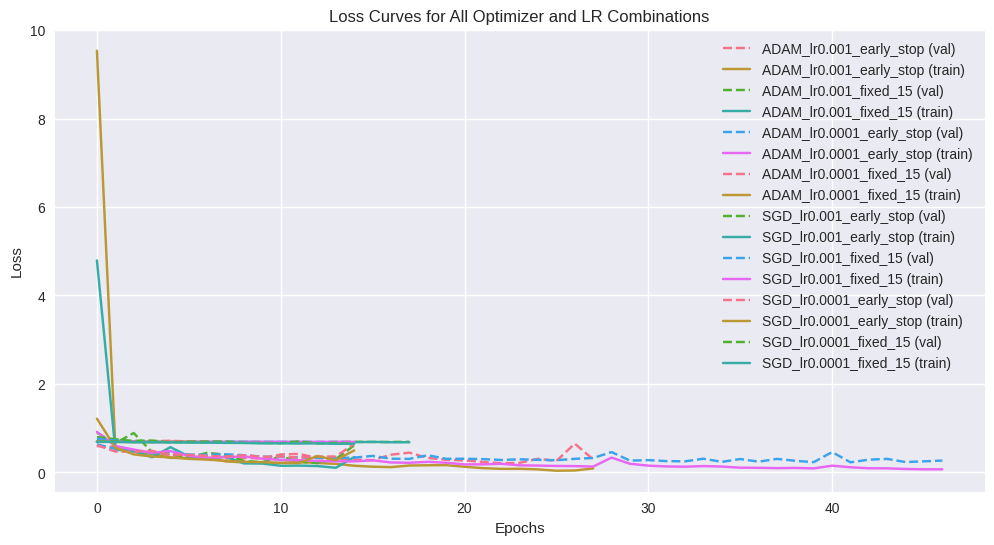

In [ ]:
def plot_loss_curves(results, title="Loss Curve Comparison"):
    plt.figure(figsize=(12, 6))
    for label, result in results.items():
        hist = result['history']
        plt.plot(hist.history['val_loss'], label=f'{label} (val)', linestyle='--')
        plt.plot(hist.history['loss'], label=f'{label} (train)')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



plot_loss_curves(results, title="Loss Curves for All Optimizer and LR Combinations")


In [ ]:
print("\n📋 Final Performance Summary:")
for label, result in results.items():
    print(f"{label}: Accuracy = {result['accuracy']:.4f} | F1 = {result['f1_score']:.4f}")



📋 Final Performance Summary:
ADAM_lr0.001_early_stop: Accuracy = 0.9213 | F1 = 0.9203
ADAM_lr0.001_fixed_15: Accuracy = 0.7978 | F1 = 0.7971
ADAM_lr0.0001_early_stop: Accuracy = 0.8989 | F1 = 0.8984
ADAM_lr0.0001_fixed_15: Accuracy = 0.7416 | F1 = 0.7383
SGD_lr0.001_early_stop: Accuracy = 0.5618 | F1 = 0.3597
SGD_lr0.001_fixed_15: Accuracy = 0.5618 | F1 = 0.3597
SGD_lr0.0001_early_stop: Accuracy = 0.5618 | F1 = 0.3597
SGD_lr0.0001_fixed_15: Accuracy = 0.5843 | F1 = 0.4498


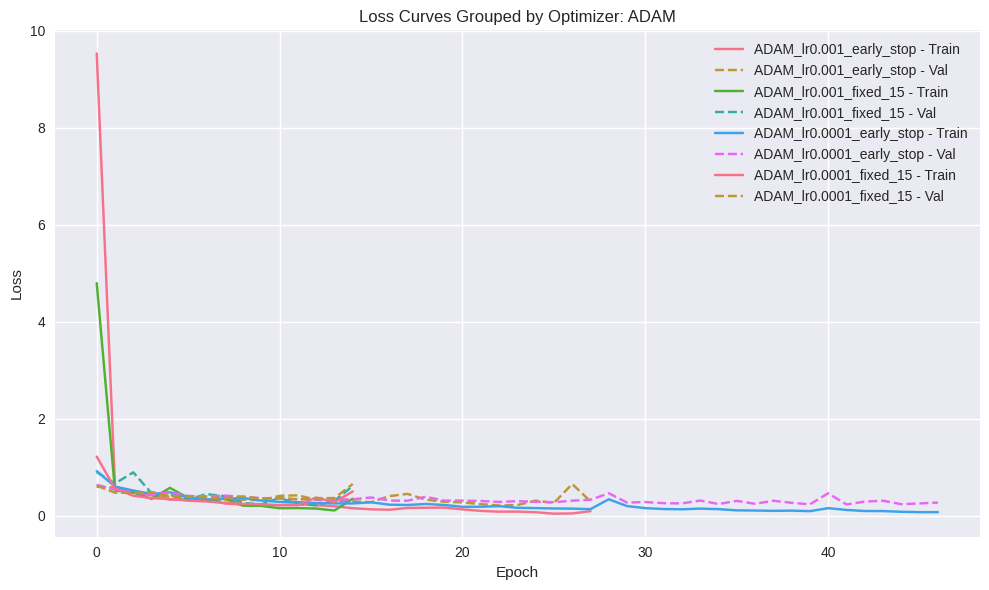

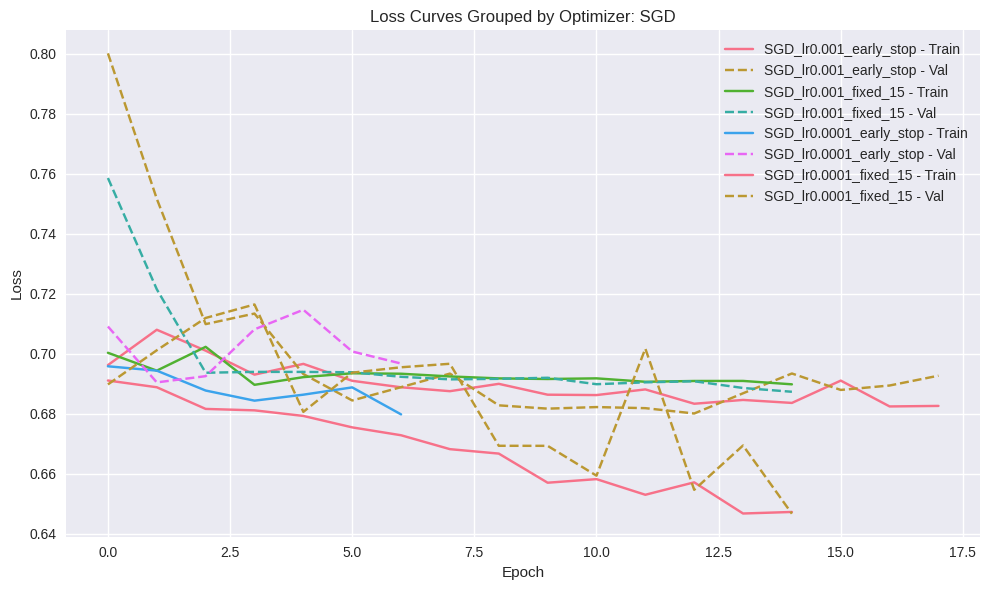

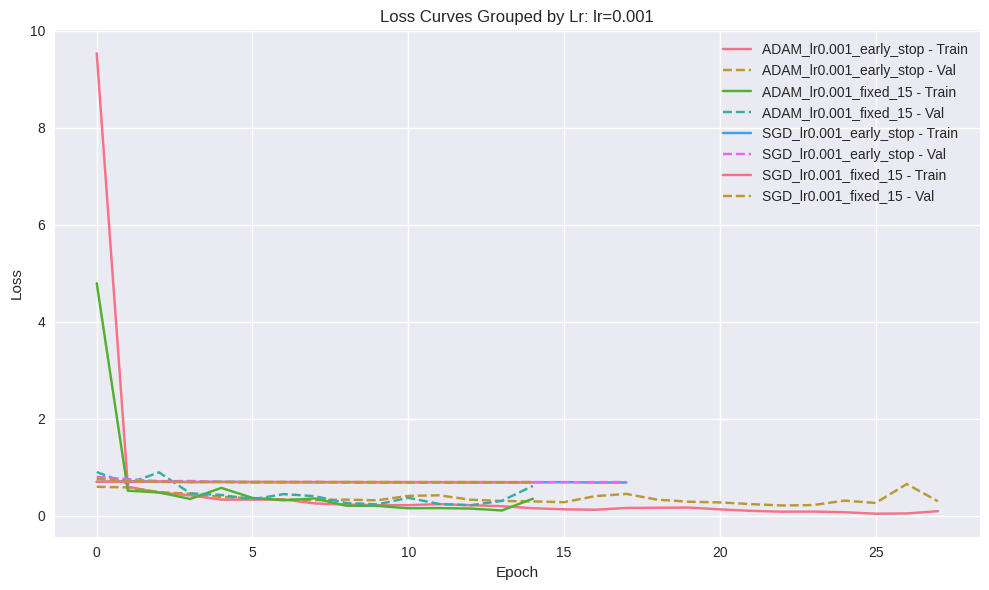

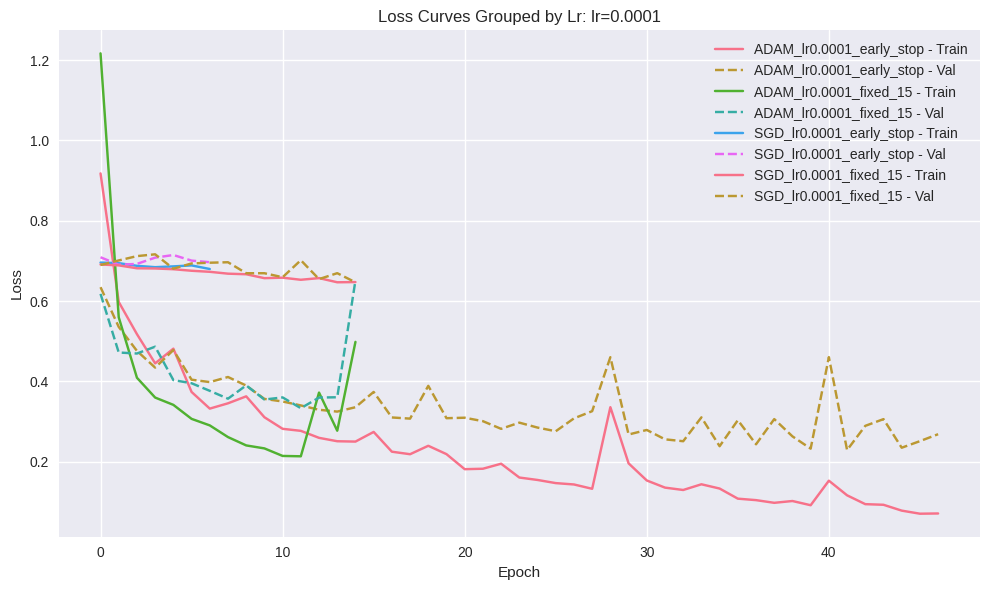

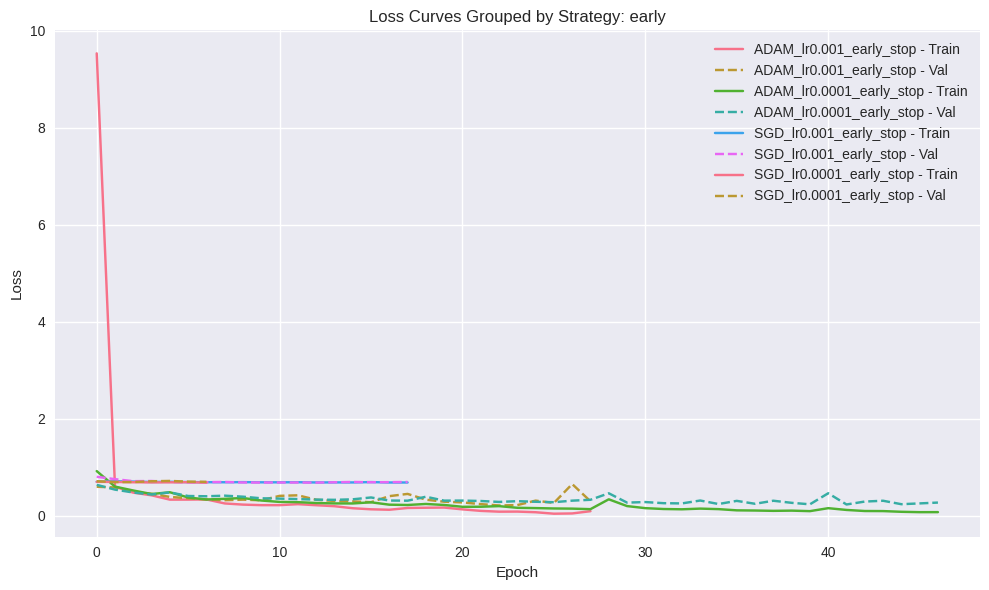

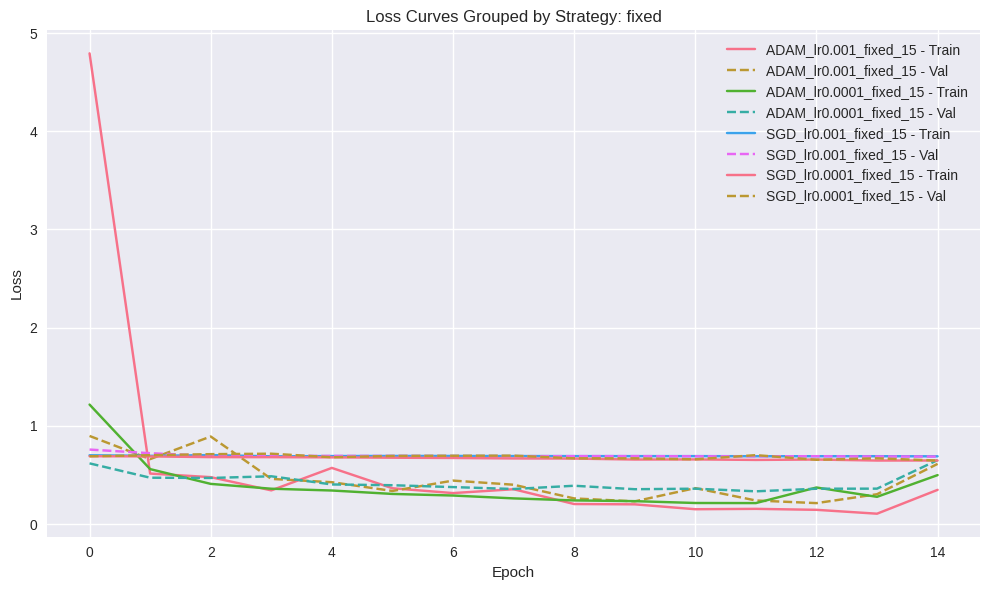

In [ ]:
import matplotlib.pyplot as plt

# Use the 'results' dictionary directly, which contains the histories
histories_for_plotting = {label: result['history'] for label, result in results.items()}


def plot_loss_by_group(group_by='optimizer'):
    """
    group_by: 'optimizer', 'lr', or 'strategy'
    """
    groups = {}
    for label, hist in histories_for_plotting.items(): # Use the histories_for_plotting dictionary
        parts = label.split('_')
        # Ensure there are enough parts before accessing
        if len(parts) < 3:
             print(f"Skipping invalid label format: {label}")
             continue

        optimizer = parts[0]
        lr = parts[1].replace('lr', '')
        strategy = parts[2]

        if group_by == 'optimizer':
            key = optimizer
        elif group_by == 'lr':
            key = f"lr={lr}"
        elif group_by == 'strategy':
            key = strategy
        else:
            raise ValueError("group_by must be 'optimizer', 'lr', or 'strategy'")

        if key not in groups:
            groups[key] = []
        groups[key].append((label, hist))

    # Plotting
    for group_name, runs in groups.items():
        plt.figure(figsize=(10, 6))
        for label, hist in runs:
            plt.plot(hist.history['loss'], label=f"{label} - Train") # Access .history attribute here
            if 'val_loss' in hist.history: # Check if val_loss exists
                plt.plot(hist.history['val_loss'], linestyle='--', label=f"{label} - Val") # Access .history attribute here
        plt.title(f"Loss Curves Grouped by {group_by.capitalize()}: {group_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Usage:
plot_loss_by_group('optimizer')   # Group loss curves by optimizer
plot_loss_by_group('lr')          # Group loss curves by learning rate
plot_loss_by_group('strategy')    # Group loss curves by training strategy